# Classification of MNIST

MNIST is a dataset consisting of handwritten numbers 0-9 widely used as a benchmark in machine learning. While the dataset is very simple, it is still in seminal papers to demonstrate proof of concept (i.e. [Dynamic Routing](https://arxiv.org/pdf/1710.09829.pdf)). Below we load some sample digits for you.

Benchmark datasets are very useful, to note a couple other widely used benchmarks: [SVHN](http://ufldl.stanford.edu/housenumbers/) (Street View House Numbers), [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) (Like MNIST, but more fashion), [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html) (10 and 100 different objects), and [ImageNet](http://www.image-net.org/) (very large real world image dataset).

We load up a downsampled MNIST dataset below. MNIST is usually 28x28, but we will work with 8x8 images.

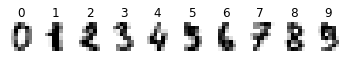

In [74]:
# Import datasets (just run this block)
%matplotlib inline

from sklearn import datasets
import matplotlib.pyplot as plt
digits = datasets.load_digits()
for index, (image, label) in enumerate(list(zip(digits.images, digits.target))[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('%i' % label)
plt.show()

# Part I

You will classifiy two numbers of your choice. Start by extracting two features from the image. We suggest looking at intensity and symmetry using `sklearn.model_selection.train_test_split`, a convenient function which will save 10% of the data for testing. We split the dataset into training and test sets. Save your test set so we can evaluate how well you classify.

`X_test` and `y_test` should be used to evaluate the performance of the classifier you build. Moving forward just work with `X_train` and `y_train`.

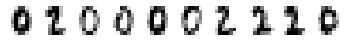

In [3]:
# in this block, you only need to modify number_a and number_b (if you wish to)
from sklearn.model_selection import train_test_split
import numpy as np

number_a = 0 # TODO choose your digit
number_b = 2 # TODO choose your digit

digit_a_indexes = np.where(digits.target==number_a) 
digit_b_indexes = np.where(digits.target==number_b)
targets = np.concatenate((digits.target[digit_a_indexes], digits.target[digit_b_indexes]))
images = np.concatenate((digits.images[digit_a_indexes], digits.images[digit_b_indexes]))
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)
for index, image in enumerate(X_train[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
plt.show()

# 1. Feature Extraction

You will create 2 feature extractors based on the numbers you choose. These will be two functions which take in an image and output a single float. Please use mean or total intensity and a metric that quantifies symmetry. You may change the digits you wish to classify to make this classification problem easier.

In [4]:
# please complete this function:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    def compute_feature_a(image):
        '''compute_feature_a will compute average intensity'''
        avg_intensity = image.mean(axis=0).mean()
        # print(image, avg_intensity)
        return avg_intensity

    def compute_feature_b(image):
        '''compute_feature_b will compute symmetry'''
        flip_ud = np.flipud(image)
        ud_symm = np.square(np.subtract(image, flip_ud))
        half_ud = int(len(ud_symm)/2)
        # print(half_ud)
        ud_symm_sum = abs(np.sum(ud_symm[0:half_ud]))/half_ud
        # print(ud_symm_sum)

        flip_lr = np.fliplr(image)
        lr_symm = np.square(np.subtract(image, flip_lr))
        half_lr= int(len(lr_symm)/2)
        lr_symm_sum = abs(np.sum(lr_symm[0:half_lr]))/half_lr

        #total_symm closer to 0 value means more symmetry

        total_symm = ud_symm_sum+lr_symm_sum

        return total_symm
    
    return compute_feature_a(image), compute_feature_b(image)

Once you compute these two features, you can apply them to your images. Don't worry about the details of the first function below, all it does is map the `compute_features` function you wrote to each image in your `X_train` variable.

Afterwards let us plot the features you've crafted to see if they can separate into two classes.

(34.0, 1189.5)

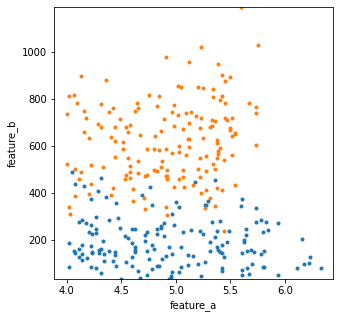

In [5]:
# Apply and plot your features (you can just run this block and inspect the output)

X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.xlabel('feature_a')
plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 

# 2. Linear Classification with Pseudo Inverse

`X_features` is a 2 dimensional array of features and `y_train` is our ground truth label. Find the best plane that separates these two classes using the pseudo inverse and plot it. For this problem, as discussed in class, we set the labels as `y=-1` for `number_a` and `y=1` for `number_b`.

The loss $L$ we would like to minimize for each $i$ row in our matrix is.

$$L  = \frac{1}{2}\Sigma (y^{(i)} - W^{T}x^{(i)})^{2}$$

where

$$x^{(i)} = 
\begin{bmatrix}
    feature_a \\
    feature_b \\
\end{bmatrix}$$

$$W = 
\begin{bmatrix}
    w_1 \\
    w_2 \\
\end{bmatrix}$$


In matrix form we convert $x^{(i)}$ into $X$ which is the number of examples we have, in our case is MNIST digit features extracted.

$$X = 
\begin{bmatrix}
    feature_{a1} & feature_{b1} \\
    feature_{a2} & feature_{b2} \\
    ... & ... \\
    feature_{ai} & feature_{bi} \\
\end{bmatrix}$$


$$L  = \frac{1}{2}( Y-XW )^{T} (Y-XW)$$


### Explain

Let's solve L analytically, by setting $\frac{d}{dW}L = 0$ and solving for $W$, showing your steps along the way. 

Step 1: $$L  = \frac{1}{2}( Y-XW )^{T} (Y-XW)$$

Step 2: $$ \frac{d}{dW}L  = \frac{d}{dW} \frac{1}{2}( Y-XW )^{T} (Y-XW)$$

Step 3: Since $ \frac{d}{dW} = 0 $:
$$0 = \frac{d}{dW} \frac{1}{2}( Y-XW )^{T} (Y-XW) $$

Step 4: And therefore:
$$0 = (Y-XW) $$

Step 5: $$Y=XW$$

Step6: $$YX^{-1} = W $$

### Compute
Going back to linear algebra, we can re-write the classification problem as $Xw = y^*$, as we did during class. Here, $X$ is our features matrix `X_features` that has the features of each data example along each row, $y^*$ is our `pseudo_y` vector, and $w$ is the unknown weights vector that we'd like to figure out.

The pseudo inverse is $$(X^{T}X)^{-1}X^{T} = X^{+}$$

Solving for $w$, $$w = X^{+}y^*$$

To perform this computation: 

#### (a) create a features vector $X$ and compute its pseudo inverse. (This is the var `X_features`)

#### (b) create a vector like $y^*$ to hold the labels. (Done below for you as `pseudo_y`)

#### (c) find $w$

In [6]:
pseudo_y = np.copy(y_train)
pseudo_y[y_train == number_a] = -1
pseudo_y[y_train == number_b] = 1

# Calculate x below
pseudo_x = np.matmul(np.linalg.inv(np.matmul(X_features.T, X_features)), X_features.T)

#Find w
w = np.matmul(pseudo_x, pseudo_y)




### (d) To examine the result of the least squares solution under this formulation, compute the train and test error using an appropriate threshold (i.e., 0). Does your trained model generalize well to the test data? 

Create a function called `accuracy_metrics` which does this.

In [7]:
def accuracy_metrics(features, label, weights, threshold):
    # features should be your X_features
    # label should be the y^{i} label
    
    # get predicted value

    predicted = np.matmul(features,weights)
    predicted[predicted<threshold] = -1
    predicted[predicted>threshold] = 1

    
    difference = predicted-label
    accuracy = (len(difference[difference==0])/len(difference))*100

    return accuracy # Return the % accuracy

print('Training accuracy: ')
print(accuracy_metrics(X_features, pseudo_y, w, 0))

# Get Pseudo_y for test data
pseudo_y_test = np.copy(y_test)
pseudo_y_test[y_test == number_a] = -1
pseudo_y_test[y_test == number_b] = 1

#generate test X_features
X_features_test = np.apply_along_axis(compute_features, 1,
                                 X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

print("Test accuracy: ")
print(accuracy_metrics(X_features_test, pseudo_y_test, w, 0))



Training accuracy: 
91.84952978056427
Test accuracy: 
91.66666666666666


### (e) Visualize the decision boundary corresponding to your chosen threshold using the provided `visualize_model` function.  

The function `visualize_model` takes in features, labels, and your calculated weights and shows a matplotlib figure. If we are using a bias term, this function assumes that the weight vector has format: `[weight0, weight1, bias]`. So bias is appended to the back of the weight vector.

In [8]:
# just run this block
def newline(weight):
    # adapted from https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941
    if len(weight) == 2:
        p1 = weight[0]
        p2 = weight[1]
        ax = plt.gca()
        xmin, xmax = ax.get_xbound()
        if(p2 == 0):
            xmin = xmax = 0
            ymin, ymax = ax.get_ybound()
        else:
            ymax = -p1/p2*(xmax)
            ymin = -p1/p2*(xmin)
        l = plt.Line2D([xmin,xmax], [ymin,ymax], color = "g", label = "Decision")
        ax.add_line(l)
       
    elif len(weight) == 3:
        p1 = weight[0]
        p2 = weight[1]
        b = weight[2]
        ax = plt.gca()
        xmin, xmax = ax.get_xbound()
        if(p2 == 0):
            xmin = xmax = b/p1
            ymin, ymax = ax.get_ybound()
        else:
            ymax = -p1/p2*(xmax) - b/p2
            ymin = -p1/p2*(xmin) - b/p2
        l = plt.Line2D([xmin,xmax], [ymin,ymax], color = "g", label = "Decision")
        ax.add_line(l)
       
    return l

def visualize_model(features, labels, weights):
    plt.figure(figsize=(5,5))
    X_features_a = features[np.where(labels==-1)]
    X_features_b = features[np.where(labels==1)]
    plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.', label = "{}".format(number_a))
    plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.', label = "{}".format(number_b))
    plt.xlabel('feature_a')
    plt.ylabel('feature_b')
    plt.ylim(features[:, 1].min(), features[:, 1].max())
    newline(weights)
    plt.gca().legend(loc = 1)
    return None

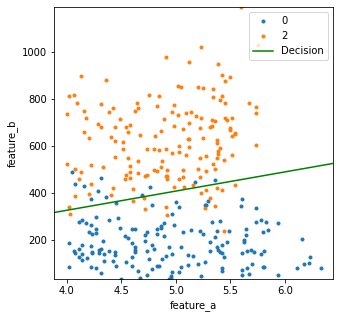

In [9]:
visualize_model(X_features, pseudo_y, w)  # should output the datapoints with the decision boundary

### (f) Repeat the above steps after adding in a bias term, allowing for the classification line to not pass through the origin. You can do this by augmenting the X feature matrix with an additional feature column of ones, and making the unknown weight vector one entry longer -- does performance improve?

If you created your functions correctly, you shouldn't need to change them and you only need to modify `X_features`. 

Training accuracy: 
92.78996865203762
Testing accuracy: 
91.66666666666666


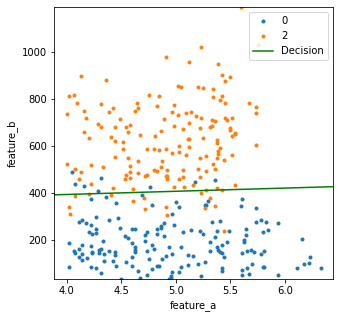

In [10]:
# Find w and bias
X_features_bias = np.append(X_features, np.ones([len(X_features),1]), axis=1)
X_features_test_bias = np.append(X_features_test, np.ones([len(X_features_test),1]), axis=1)
pseudo_x_bias = np.matmul(np.linalg.inv(np.matmul(X_features_bias.T, X_features_bias)), X_features_bias.T)
w_bias = np.matmul(pseudo_x_bias, pseudo_y)

# Get the test and train accuracy of your model with bias
print('Training accuracy: ')
print(accuracy_metrics(X_features_bias, pseudo_y, w_bias, 0))

print('Testing accuracy: ')
print(accuracy_metrics(X_features_test_bias, pseudo_y_test, w_bias, 0))


# Visualize the model, you may need to change your code.
visualize_model(X_features_bias, pseudo_y, w_bias)

# 3. Linear Classification with Finite Differences

Rather than use pseudo inverse (analytically solving your optimization equation). Instead, initialize your parameter x to some random numbers. Move x some small epsilon amount in the each direction to compute the total change in your loss and calculate the gradient. Then update x by taking a small step in that gradient direction. You can execute this in a for loop for a set number of iterations, or until the gradient reaches some threshold value of not changing very much.

1. Solve for x
2. Get training and test accuracy every $n$ steps
3. Plot the decision boundary every $n$ steps

### Define a loss.

In [202]:
def loss(features, labels, weights):
    predicted = np.matmul(features, weights)
    mean_square_error = np.sum(np.square(predicted-labels))/features.shape[0]

    return mean_square_error

### Now iteratively solve for your weights w, which includes the bias term.

Training accuracy 0 th step: 
50.15673981191222
Testing accuracy 0 th step: 
50.0
Training accuracy 50 th step: 
91.84952978056427
Testing accuracy 50 th step: 
94.44444444444444
Training accuracy 100 th step: 
91.84952978056427
Testing accuracy 100 th step: 
94.44444444444444
Training accuracy 150 th step: 
91.84952978056427
Testing accuracy 150 th step: 
94.44444444444444
Training accuracy 200 th step: 
91.84952978056427
Testing accuracy 200 th step: 
94.44444444444444
Training accuracy 250 th step: 
91.84952978056427
Testing accuracy 250 th step: 
94.44444444444444
Training accuracy 300 th step: 
91.84952978056427
Testing accuracy 300 th step: 
94.44444444444444
Training accuracy 350 th step: 
91.84952978056427
Testing accuracy 350 th step: 
94.44444444444444
Training accuracy 400 th step: 
91.84952978056427
Testing accuracy 400 th step: 
94.44444444444444
Training accuracy 450 th step: 
91.84952978056427
Testing accuracy 450 th step: 
94.44444444444444


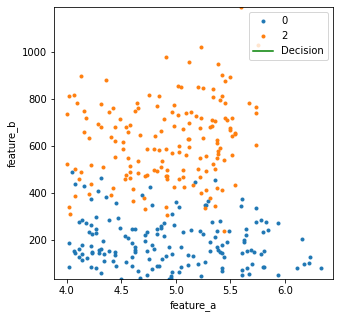

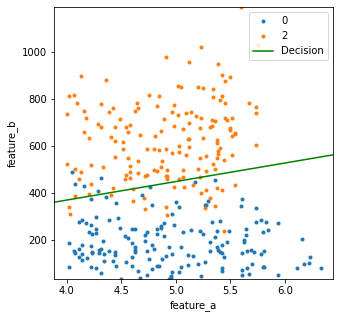

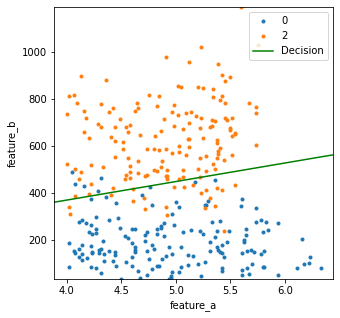

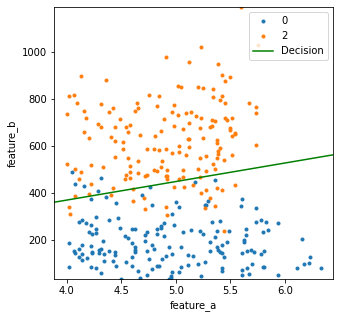

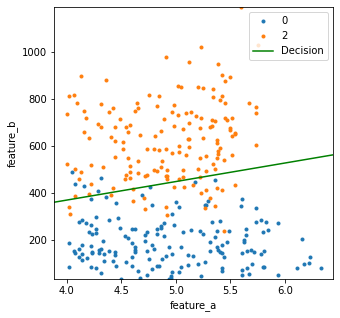

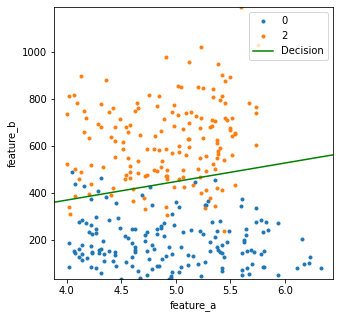

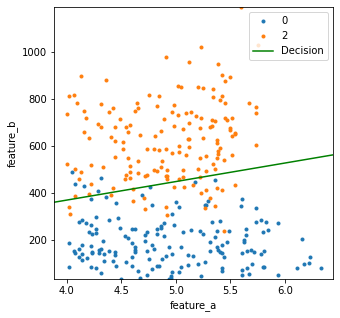

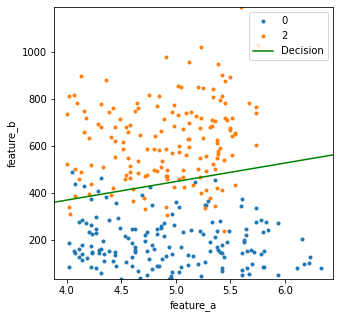

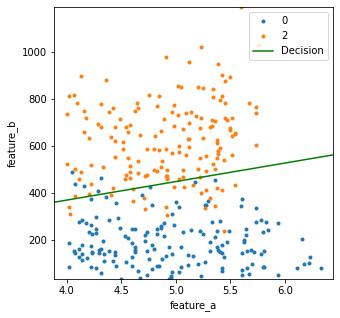

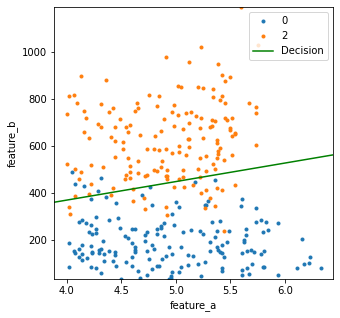

In [224]:
w = -np.random.rand(3) # init weights to some random value.
num_iterations = 500 # set this to the number of iterations
delta = 1e-4 # This may need to be adjusted
step_size = 1e-6 # This may also need to be adjusted
grad = np.ones((3,))
interval=50
for i in range(num_iterations):
  # move w0 some delta and calculate derivative in w0 direction
  w0 = np.copy(w)
  w0[0]+=delta
  grad[0] = (loss(X_features_bias, pseudo_y, w0)-loss(X_features_bias, pseudo_y, w))/delta
  #move w1 some delta and calculate derivative in w1 direction
  w1 = np.copy(w)
  w1[1]+=delta
  grad[1] = (loss(X_features_bias, pseudo_y, w1)-loss(X_features_bias, pseudo_y, w))/delta
  # update w0 and w1 some step_size in the direction of steepest descent
  w -= step_size * grad

  #print every interval otherwise it spams the output
  if i % interval == 0:
    print('Training accuracy', str(i), 'th step: ')
    print(accuracy_metrics(X_features_bias, pseudo_y, w, 0))
    print('Testing accuracy', str(i), 'th step: ')
    print(accuracy_metrics(X_features_test_bias, pseudo_y_test, w, 0))
    visualize_model(X_features_bias, pseudo_y, w)

# 4. Logistic Classification with Finite Differences

Now, let's consider the same problem with a different loss function.

$$L = \frac{1}{N}\sum_{i=1}^n ln(1 + e^{-y^{(i)}W^{T}x^{(i)}})$$

Use finite differences to compute the gradient and iteratively calculate $W$

1. Solve for x
2. Get training and test accuracy every $n$ steps
3. Plot the decision boundary every $n$ steps


In [11]:
logistic_y = np.copy(y_train)
logistic_y[y_train == number_a] = -1
logistic_y[y_train == number_b] = 1

logistic_y_test = np.copy(y_test)
logistic_y_test[y_test == number_a] = -1
logistic_y_test[y_test == number_b] = 1


In [12]:
def logistic_loss(features, labels, weights):
    log_loss = 0
    for i in range(features.shape[0]):
        pred = (np.matmul(features[i,:], weights))
        pred = pred.astype(np.float64)
        cur_loss = np.log(1+np.exp(np.float64(-labels[i]*pred)))
        log_loss += cur_loss

    return log_loss/features.shape[0]

Training accuracy  0 th step: 
50.15673981191222
Testing accuracy  0 th step: 
50.0
Training accuracy  200 th step: 
50.15673981191222
Testing accuracy  200 th step: 
50.0
Training accuracy  400 th step: 
50.15673981191222
Testing accuracy  400 th step: 
50.0
Training accuracy  600 th step: 
50.15673981191222
Testing accuracy  600 th step: 
50.0
Training accuracy  800 th step: 
90.28213166144201
Testing accuracy  800 th step: 
91.66666666666666
Training accuracy  1000 th step: 
91.84952978056427
Testing accuracy  1000 th step: 
91.66666666666666
Training accuracy  1200 th step: 
91.84952978056427
Testing accuracy  1200 th step: 
91.66666666666666
Training accuracy  1400 th step: 
91.84952978056427
Testing accuracy  1400 th step: 
91.66666666666666
Training accuracy  1600 th step: 
91.84952978056427
Testing accuracy  1600 th step: 
91.66666666666666
Training accuracy  1800 th step: 
91.84952978056427
Testing accuracy  1800 th step: 
91.66666666666666


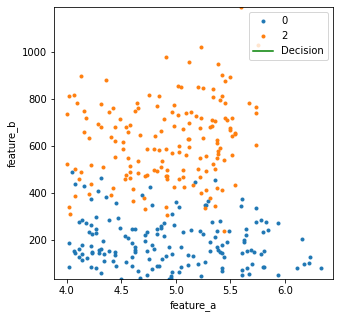

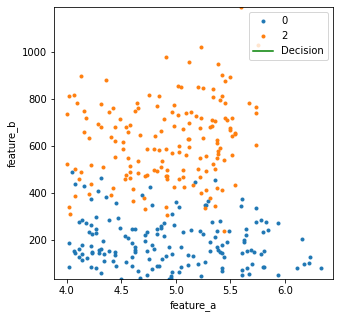

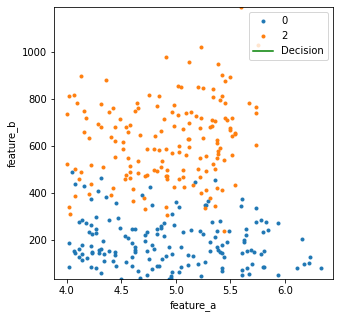

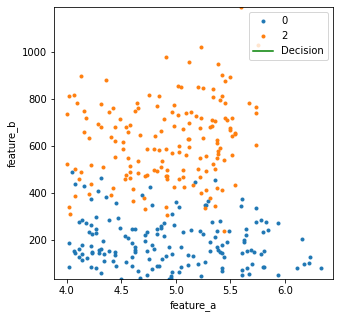

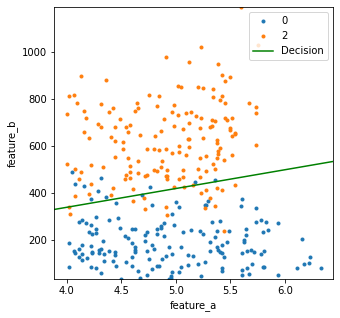

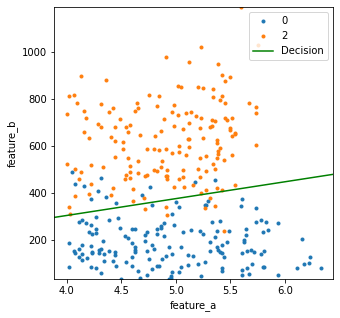

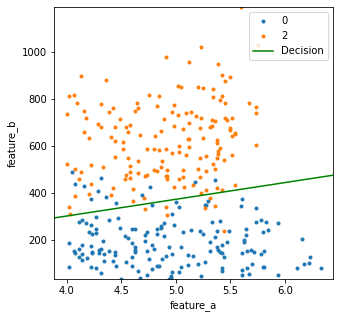

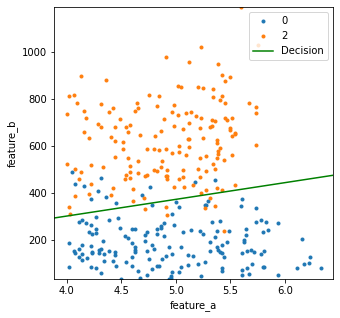

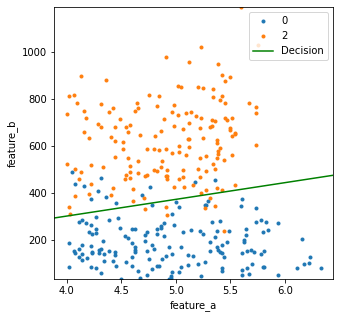

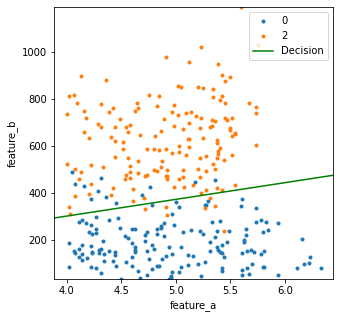

In [14]:
num_iterations = 2000 # set this to the number of iterations
delta = 1e-4 # This may need to be adjusted
interval = num_iterations/10
step_size = 1e-6

w = -np.random.rand(3) # init weights to some random value.
grad = np.ones((3,))
for i in range(num_iterations):
  # move w0 some delta and calculate derivative in w0 direction
    w1 = np.copy(w)
    w1[0] = w1[0]+delta
    grad[0] = (logistic_loss(X_features_bias, logistic_y, w1)-logistic_loss(X_features_bias, logistic_y, w))/delta
    w2 = np.copy(w)
    w2[1] = w2[1]+delta
    grad[1] = (logistic_loss(X_features_bias, logistic_y, w2)-logistic_loss(X_features_bias, logistic_y, w))/delta
    w -= step_size * (grad)
    if i % interval == 0:
        print('Training accuracy ', str(i), 'th step: ')
        print(accuracy_metrics(X_features_bias, logistic_y, w, 0.5))

        print('Testing accuracy ', str(i), 'th step: ')
        print(accuracy_metrics(X_features_test_bias, logistic_y_test, w, 0.5))
    
        visualize_model(X_features_bias, logistic_y, w)



# Part II

In Parts II and III, we'll add some very small modifications to the above code that you just wrote, and will re-run it to examine how the performance changes. 

For Part II, let’s repeat the exercise above (Part I), but using a different set of features (you don't have to redo the pseudo-inverse derivation or anything like that - just change how you're defining the two features of interest in the associated fucntion). Here, let’s assume that we have a camera that has just two pixels in it, which is taking pictures of the MNIST image dataset. One of these two pixels will detect the total intensity from the top half of each digit to form feature x_1, and the other pixel will detect the total intensity from the bottom half of each digit to form feature x_2. Please use these two top/bottom total intensities to form a new feature vector for each MNIST image that you’re using for classification, and repeat the exercise above to obtain a plot of classification performance and an average classification accuracy score. 

**Note that this classification score (in some sense) reflects what would be possible with a "normal" camera.**

 - Plot Points after feature generation
 - Linear Classification (Pseudo or Gradient method)
   - test/train accuracy
 - Logistic Classification
   - test/train accuracy

In [15]:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    def compute_feature_a(image):
        '''compute_feature_a will compute ...'''
        top_half = np.sum(image[0:4, :])

        return top_half

    def compute_feature_b(image):
        '''compute_feature_b will compute ...'''
        bottom_half = np.sum(image[4:8, :])

        return bottom_half
    
    return compute_feature_a(image), compute_feature_b(image)

(56.0, 260.0)

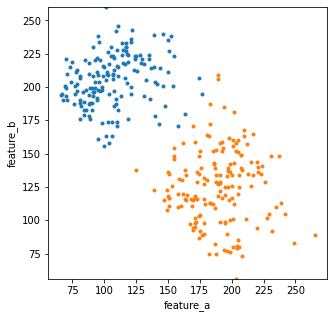

In [16]:
# Choose digits and evaluate features
from sklearn.model_selection import train_test_split
import numpy as np

number_a = 6 # TODO choose your digit
number_b = 9 # TODO choose your digit

digit_a_indexes = np.where(digits.target==number_a) 
digit_b_indexes = np.where(digits.target==number_b)
targets = np.concatenate((digits.target[digit_a_indexes], digits.target[digit_b_indexes]))
images = np.concatenate((digits.images[digit_a_indexes], digits.images[digit_b_indexes]))
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)

# define features and plot
X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_features_test = np.apply_along_axis(compute_features, 1,
                                 X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.xlabel('feature_a')
plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 

Training accuracy: 
98.76543209876543
Testing accuracy: 
100.0


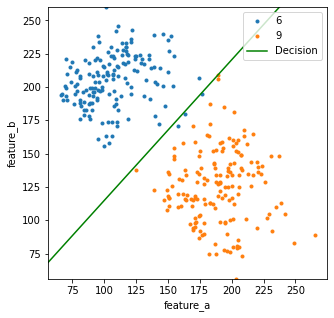

In [17]:
# evaluate linear classification using pseudoinverse method
pseudo_y = np.copy(y_train)
pseudo_y[y_train == number_a] = -1
pseudo_y[y_train == number_b] = 1

pseudo_y_test = np.copy(y_test)
pseudo_y_test[y_test == number_a] = -1
pseudo_y_test[y_test == number_b] = 1

# Pseudo method
X_features_bias = np.append(X_features, np.ones([len(X_features),1]), axis=1)
X_features_test_bias = np.append(X_features_test, np.ones([len(X_features_test),1]), axis=1)
pseudo_x_bias = np.matmul(np.linalg.inv(np.matmul(X_features_bias.T, X_features_bias)), X_features_bias.T)
w_bias = np.matmul(pseudo_x_bias, pseudo_y)

# Get the test and train accuracy of your model with bias
print('Training accuracy: ')
print(accuracy_metrics(X_features_bias, pseudo_y, w_bias, 0))

print('Testing accuracy: ')
print(accuracy_metrics(X_features_test_bias, pseudo_y_test, w_bias, 0))

# Visualize the model, you may need to change your code.
visualize_model(X_features_bias, pseudo_y, w_bias)

In [18]:
logistic_y = np.copy(y_train)
logistic_y[y_train == number_a] = -1
logistic_y[y_train == number_b] = 1

logistic_y_test = np.copy(y_test)
logistic_y_test[y_test == number_a] = -1
logistic_y_test[y_test == number_b] = 1

Training accuracy without bias at  0 th step: 
61.419753086419746
Testing accuracy without bias at  0 th step: 
72.97297297297297
Training accuracy without bias at  20 th step: 
99.07407407407408
Testing accuracy without bias at  20 th step: 
100.0
Training accuracy without bias at  40 th step: 
99.07407407407408
Testing accuracy without bias at  40 th step: 
100.0
Training accuracy without bias at  60 th step: 
99.07407407407408
Testing accuracy without bias at  60 th step: 
100.0
Training accuracy without bias at  80 th step: 
99.07407407407408
Testing accuracy without bias at  80 th step: 
100.0
Training accuracy without bias at  100 th step: 
99.07407407407408
Testing accuracy without bias at  100 th step: 
100.0
Training accuracy without bias at  120 th step: 
99.07407407407408
Testing accuracy without bias at  120 th step: 
100.0
Training accuracy without bias at  140 th step: 
99.07407407407408
Testing accuracy without bias at  140 th step: 
100.0
Training accuracy without bias 

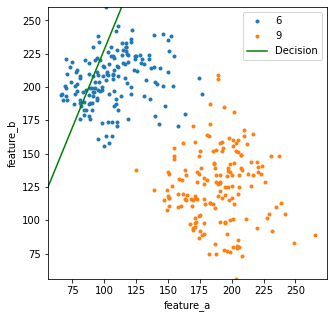

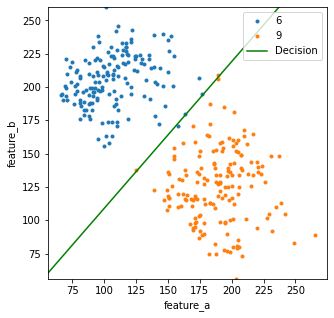

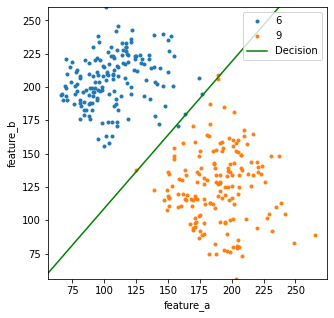

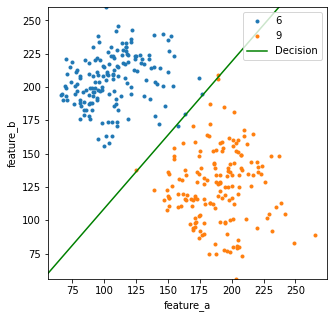

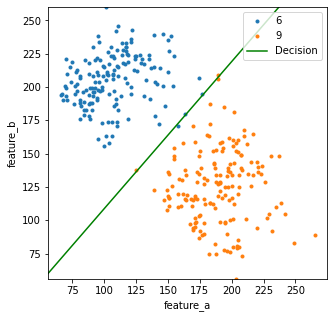

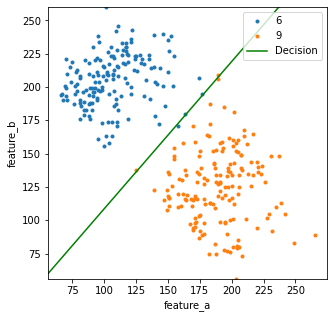

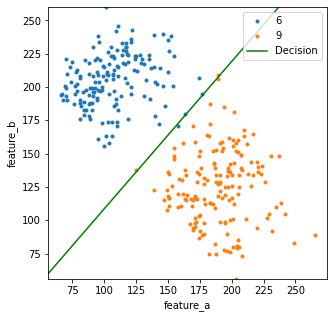

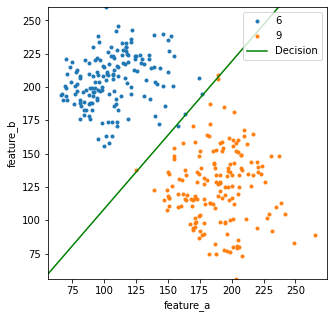

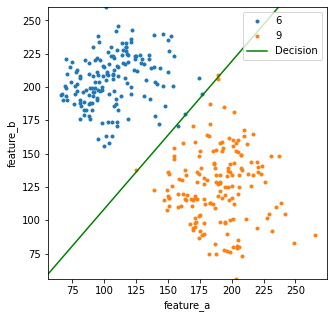

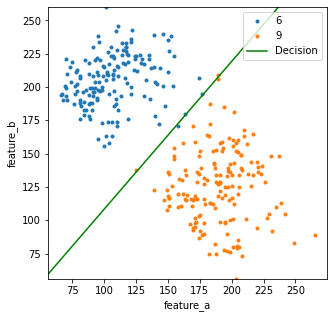

In [19]:
num_iterations = 200 # set this to the number of iterations
delta = 1e-2 # This may need to be adjusted
interval = num_iterations/10
step_size = 1e-2

w = -np.random.rand(3) # init weights to some random value.
grad = np.ones((3,))
for i in range(num_iterations):
  # move w0 some delta and calculate derivative in w0 direction
    w1 = np.copy(w)
    w1[0] = w1[0]+delta
    grad[0] = (logistic_loss(X_features_bias, logistic_y, w1)-logistic_loss(X_features_bias, logistic_y, w))/delta
    w2 = np.copy(w)
    w2[1] = w2[1]+delta
    grad[1] = (logistic_loss(X_features_bias, logistic_y, w2)-logistic_loss(X_features_bias, logistic_y, w))/delta
    w -= step_size * (grad)
    if i % interval == 0:
        print('Training accuracy without bias at ', str(i), 'th step: ')
        print(accuracy_metrics(X_features_bias, logistic_y, w, 0))

        print('Testing accuracy without bias at ', str(i), 'th step: ')
        print(accuracy_metrics(X_features_test_bias, logistic_y_test, w, 0))
    
        visualize_model(X_features_bias, logistic_y, w)



# Part III

Once again, in Part III, we'll add a very small modification to your code in Part II. Here, let’s assume that this camera has a special filter in its lens that blurs the MNIST image in a special way before it is detected. Let’s model this 2D blur as a convolution with the 3x3 filter below.

$$X = 
\begin{bmatrix}
    -1 & 0 & 1 \\
    -1 & 0 & 1 \\
    -1 & 0 & 1 \\
\end{bmatrix}$$

Convolve the set of MNIST images with this kernel before proceeding to compute the two features of interest as in Part I: the total image intensity, and the image symmetry. Repeat the exercise above to obtain a plot of classification performance and an average classification accuracy score.

**Note that this classification score (in some sense) reflects what would be possible with a “computational” camera, which has a special aperture shape for enhanced image classification.**

 - Plot Points after feature generation
 - Linear Classification (Pseudo or Gradient method)
   - test/train accuracy
 - Logistic Classification
   - test/train accuracy

In [198]:
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
import numpy as np

number_a = 1 # TODO choose your digit
number_b = 2 # TODO choose your digit

digit_a_indexes = np.where(digits.target==number_a) 
digit_b_indexes = np.where(digits.target==number_b)
targets = np.concatenate((digits.target[digit_a_indexes], digits.target[digit_b_indexes]))
images = np.concatenate((digits.images[digit_a_indexes], digits.images[digit_b_indexes]))

kernel = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

# convolution
for i in range(images.shape[0]):
  images[i,:,:] = convolve2d(images[i,:,:], kernel, mode="same")

X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)

# plot points after feature generation

In [177]:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    def compute_feature_a(image):
        '''compute_feature_a will compute average intensity'''
        avg_intensity = image.mean(axis=0).mean()
        # print(image, avg_intensity)
        return avg_intensity

    def compute_feature_b(image):
        '''compute_feature_b will compute symmetry'''
        flip_ud = np.flipud(image)
        ud_symm = np.square(np.subtract(image, flip_ud))
        half_ud = int(len(ud_symm)/2)
        # print(half_ud)
        ud_symm_sum = abs(np.sum(ud_symm[0:half_ud]))/half_ud
        # print(ud_symm_sum)

        flip_lr = np.fliplr(image)
        lr_symm = np.square(np.subtract(image, flip_lr))
        half_lr= int(len(lr_symm)/2)
        lr_symm_sum = abs(np.sum(lr_symm[0:half_lr]))/half_lr

        #total_symm closer to 0 value means more symmetry

        total_symm = ud_symm_sum+lr_symm_sum

        return total_symm/1000 #symmetry needs to be divided by 1000 otherwise
        # numpy throws a NaN for the logistic loss function due to the
        # exponential term and doesn't fit correctly
    
    return compute_feature_a(image), compute_feature_b(image)

(5.476, 29.3975)

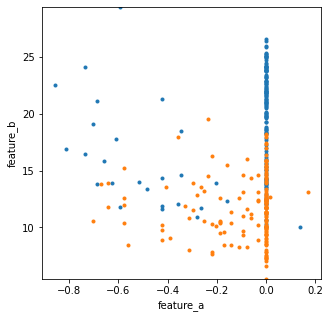

In [178]:
X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_features_test = np.apply_along_axis(compute_features, 1,
                                 X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.xlabel('feature_a')
plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 

Training accuracy: 
79.25696594427245
Testing accuracy: 
75.0


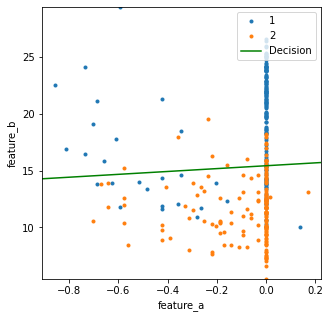

In [179]:
# evaluate linear classification using pseudoinverse method
pseudo_y = np.copy(y_train)
pseudo_y[y_train == number_a] = -1
pseudo_y[y_train == number_b] = 1

pseudo_y_test = np.copy(y_test)
pseudo_y_test[y_test == number_a] = -1
pseudo_y_test[y_test == number_b] = 1

# Pseudo method
X_features_bias = np.append(X_features, np.ones([len(X_features),1]), axis=1)
X_features_test_bias = np.append(X_features_test, np.ones([len(X_features_test),1]), axis=1)
pseudo_x_bias = np.matmul(np.linalg.inv(np.matmul(X_features_bias.T, X_features_bias)), X_features_bias.T)
w_bias = np.matmul(pseudo_x_bias, pseudo_y)

# Get the test and train accuracy of your model with bias
print('Training accuracy: ')
print(accuracy_metrics(X_features_bias, pseudo_y, w_bias, 0))

print('Testing accuracy: ')
print(accuracy_metrics(X_features_test_bias, pseudo_y_test, w_bias, 0))

# Visualize the model, you may need to change your code.
visualize_model(X_features_bias, pseudo_y, w_bias)

[-0.90350998 -0.0138251  -0.46638671]
Training accuracy 0 th step: 
50.77399380804953
Testing accuracy 0 th step: 
50.0
Boundary at  0 th step: 
[-0.91329369  0.04475296 -1.46638671]
Training accuracy 100 th step: 
48.91640866873065
Testing accuracy 100 th step: 
50.0
Boundary at  100 th step: 
[-0.92664106  0.1010344  -2.46638671]
Training accuracy 200 th step: 
44.27244582043344
Testing accuracy 200 th step: 
44.44444444444444
Boundary at  200 th step: 
[-0.9433761   0.15617848 -3.46638671]
Training accuracy 300 th step: 
34.6749226006192
Testing accuracy 300 th step: 
30.555555555555557
Boundary at  300 th step: 
[-0.96315453  0.21034613 -4.46638671]
Training accuracy 400 th step: 
29.411764705882355
Testing accuracy 400 th step: 
30.555555555555557
Boundary at  400 th step: 
[-0.98555178  0.26368251 -5.46638671]
Training accuracy 500 th step: 
27.24458204334365
Testing accuracy 500 th step: 
30.555555555555557
Boundary at  500 th step: 
[-1.01013643  0.31631429 -6.46638671]
Trainin

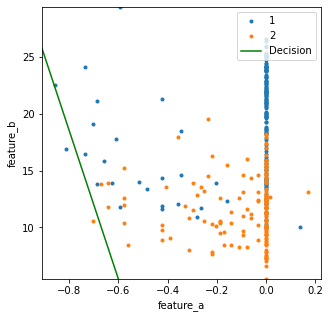

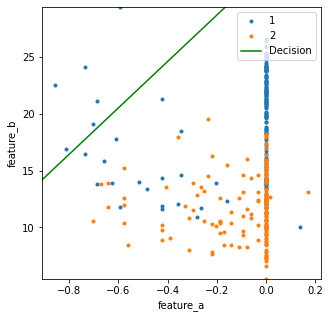

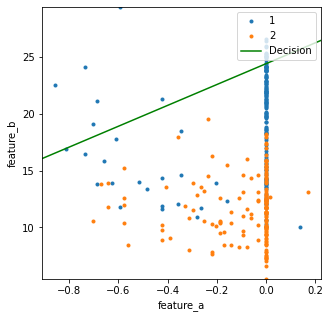

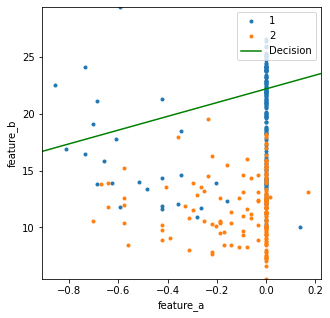

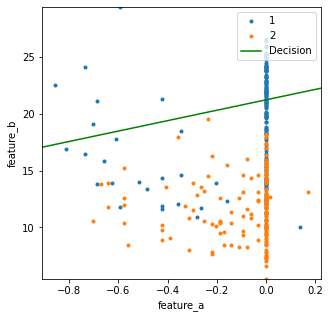

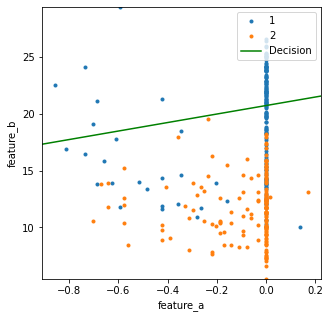

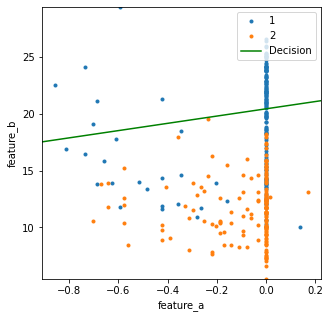

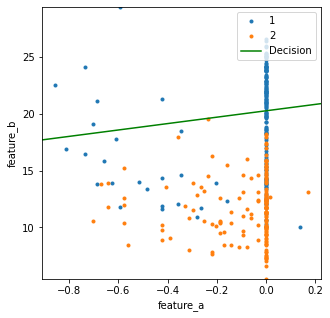

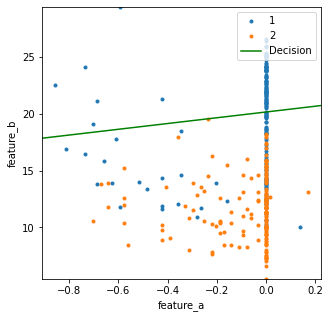

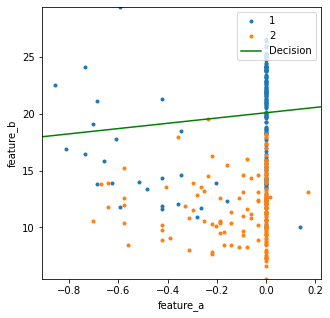

In [195]:
logistic_y = np.copy(y_train)
logistic_y[y_train == number_a] = -1
logistic_y[y_train == number_b] = 1

logistic_y_test = np.copy(y_test)
logistic_y_test[y_test == number_a] = -1
logistic_y_test[y_test == number_b] = 1

def logistic_loss(features, labels, weights):
    log_loss = 0
    for i in range(features.shape[0]):
        pred = (np.matmul(features[i,:], weights))
        pred = pred.astype(np.float64)
        cur_loss = np.log(1+np.exp(np.float64(-labels[i]*pred)))
        log_loss += cur_loss

    return log_loss/features.shape[0]
num_iterations = 1000
delta = 1e-2
interval = num_iterations/10
step_size = 1e-2

w = -np.random.rand(3) # init weights to some random value.
# print(w)
grad = np.ones((3,))
for i in range(num_iterations):
    w1 = np.copy(w)
    w1[0] = w1[0]+delta
    w2 = np.copy(w)
    w2[1] = w2[1]+delta
    grad[0] = (logistic_loss(X_features_bias, logistic_y, w1)-logistic_loss(X_features_bias, logistic_y, w))/delta
    grad[1] = (logistic_loss(X_features_bias, logistic_y, w2)-logistic_loss(X_features_bias, logistic_y, w))/delta
    w -= step_size * (grad)
    if i % interval == 0:
        print(w)
        print('Training accuracy', str(i), 'th step: ')
        print(accuracy_metrics(X_features_bias, logistic_y, w, 0))

        print('Testing accuracy', str(i), 'th step: ')
        print(accuracy_metrics(X_features_test_bias, logistic_y_test, w, 0))
        
        print('Boundary at ', str(i), 'th step: ')
        visualize_model(X_features_bias, logistic_y, w)